This notebook shows how to apply Neural Networks to predict the global temperature, based on the time series of CO2 & CH4.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

## Some visualization of the ClimateBench data

Before training ML models, let's plot the ClimateBench dataset for quick checking.

<a href="https://github.com/duncanwp/ClimateBench.git">ClimateBench</a> is a spatial-temporal dataset that contains simulations generated by the NorESM2 model. It provides both historical simulations & future projections under different scenarios (e.g., ssp245).

Four future scenarios are plotted here: `ssp126, ssp245, ssp370, ssp585`.

reference: <a href="https://doi.org/10.1029/2021MS002954">Watson‐Parris, D., Rao, Y., Olivié, D., Seland, Ø., Nowack, P., Camps‐Valls, G., ... & Roesch, C. (2022). ClimateBench v1. 0: A Benchmark for Data‐Driven Climate Projections. Journal of Advances in Modeling Earth Systems, 14(10), e2021MS002954.</a>

In [4]:
scenarios = ['historical','ssp126','ssp370','ssp585']
inputs = [os.path.join(train_path , f"inputs_{scenario}") for scenario in scenarios]
inputs.append(os.path.join(test_path, "inputs_ssp245"))
inputs.sort(key=lambda x:x.split('_')[-1])

outputs = [os.path.join(train_path , f"outputs_{scenario}") for scenario in scenarios]
outputs.append(os.path.join(test_path, "outputs_ssp245"))
outputs.sort(key=lambda x:x.split('_')[-1])

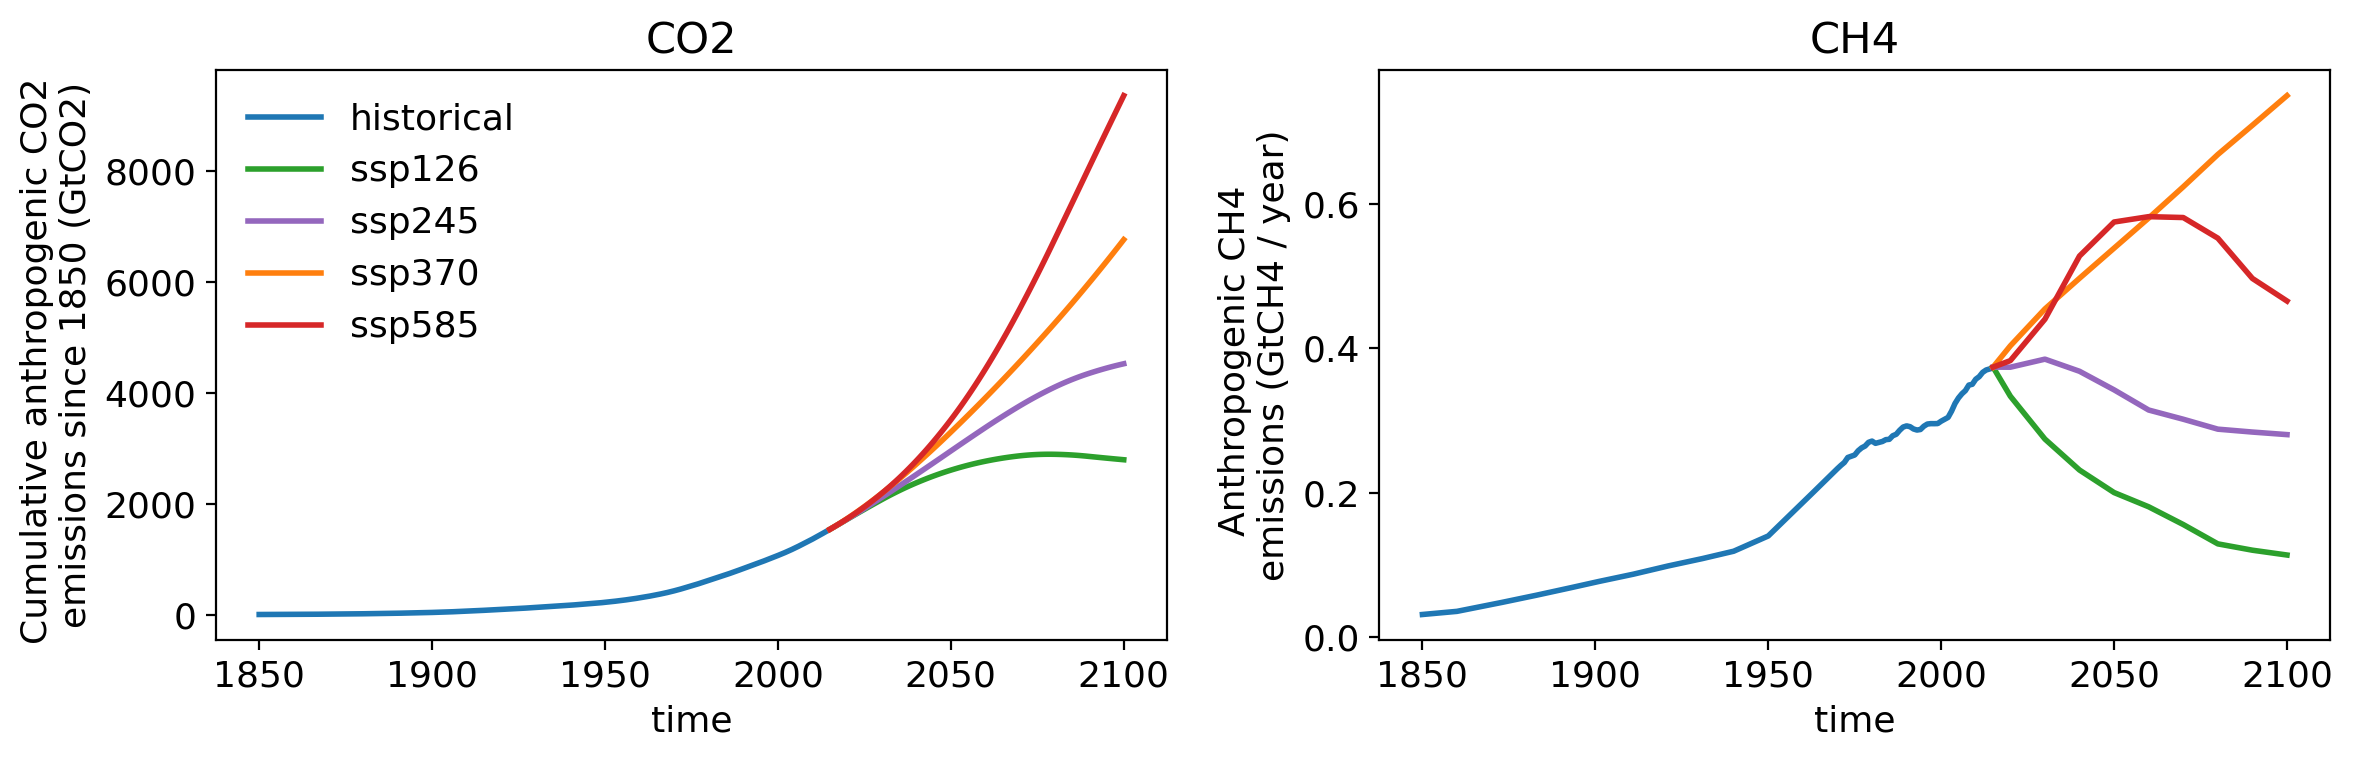

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
colors  = ['tab:blue','tab:green','tab:purple','tab:orange','tab:red']


for i,input in enumerate(inputs):

    label=input.split('_')[-1]#[:-3]
    X = open_dataset(input)
    x = X.time.data
    
    X['CO2'].plot(label=label,color=colors[i],linewidth=2,ax=axes[0])
    axes[0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
    
    X['CH4'].plot(label=label,color=colors[i],linewidth=2,ax=axes[1])
    axes[1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
    
axes[0].set_title('CO2')
axes[1].set_title('CH4')
axes[0].legend()
plt.tight_layout()

/tmp/ipykernel_568/3503487954.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])
/tmp/ipykernel_568/3503487954.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])
/tmp/ipykernel_568/3503487954.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])
/tmp/ipykernel_568/3503487954.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])
/tmp/ipykernel_568/3503487954.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])


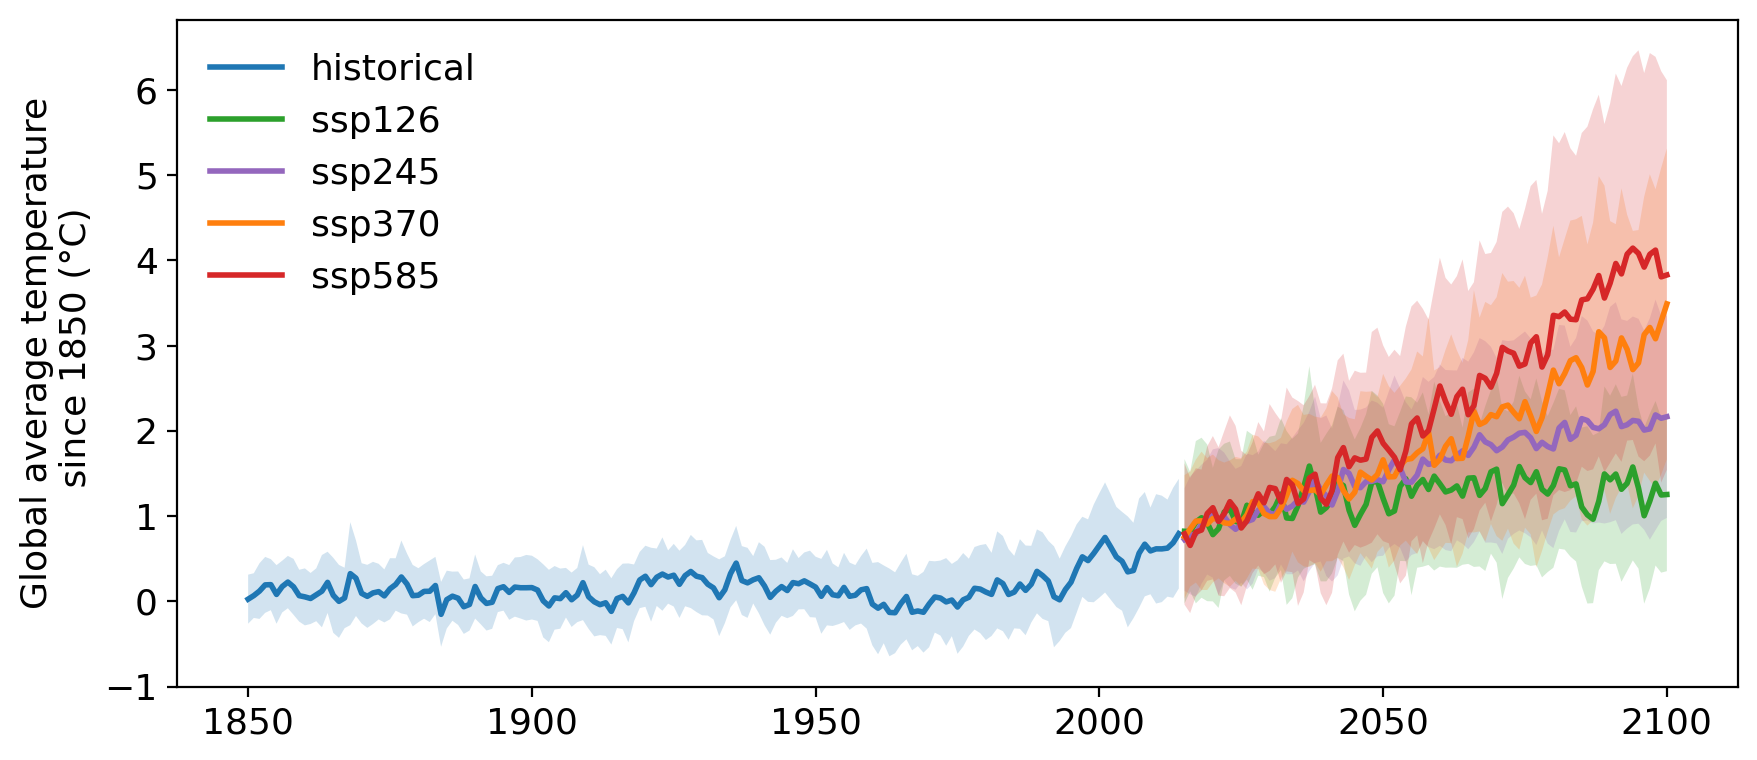

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(9,4))

for i,output in enumerate(outputs):

    label=output.split('_')[-1]
    X = open_dataset(output).mean(dim="member")[['tas']].drop(['quantile'])
    x = X.time.data
    
    weights  = np.cos(np.deg2rad(X.lat))
    tas_mean = X['tas'].weighted(weights).mean(['lat', 'lon']).data
    tas_std  = X['tas'].weighted(weights).std(['lat', 'lon']).data
    
    ax.plot(x, tas_mean, label=label,color=colors[i],linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=colors[i],alpha=0.2)
    
ax.set_ylabel("Global average temperature\n since 1850 (°C)")
ax.legend()
plt.tight_layout()


/tmp/ipykernel_568/2452594994.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  y_his    = open_dataset(os.path.join(train_path , "outputs_historical")).mean(dim="member")[['tas']].drop(['quantile'])
/tmp/ipykernel_568/2452594994.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop(['quantile'])


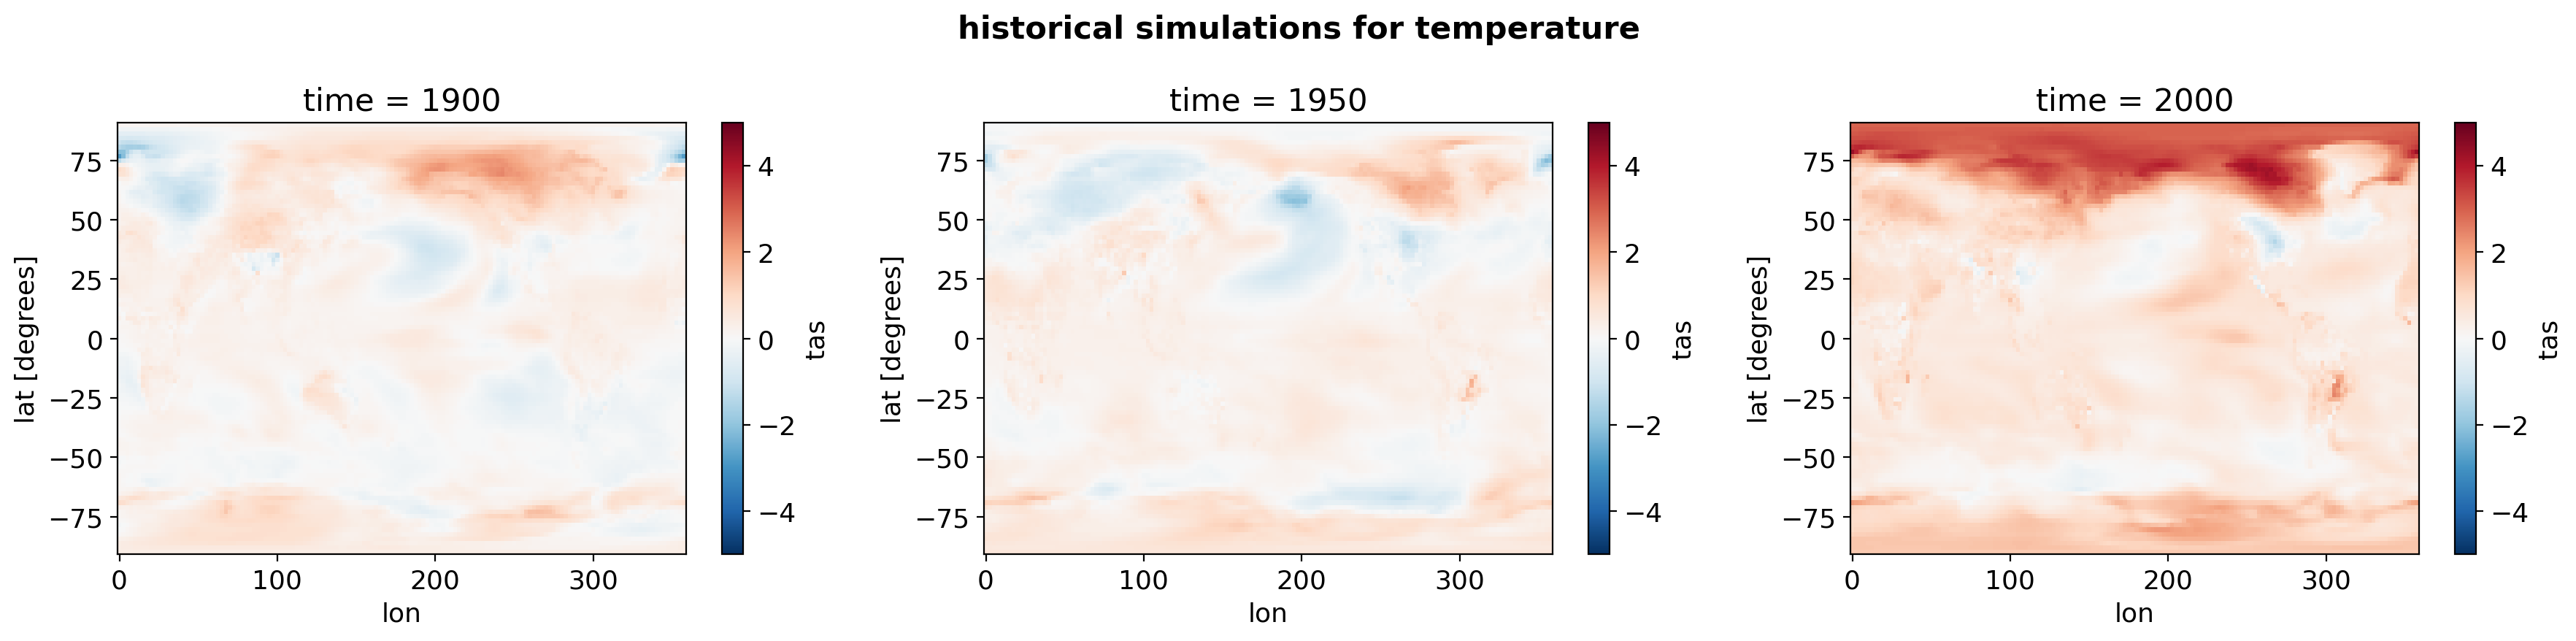

In [7]:
y_his    = open_dataset(os.path.join(train_path , "outputs_historical")).mean(dim="member")[['tas']].drop(['quantile'])
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop(['quantile'])


fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 1900, 1950, 2000
vmin, vmax = -5, 5

y_his.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_his.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_his.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('historical simulations for temperature',fontweight='bold')
plt.tight_layout()

/tmp/ipykernel_568/3911684878.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop(['quantile'])


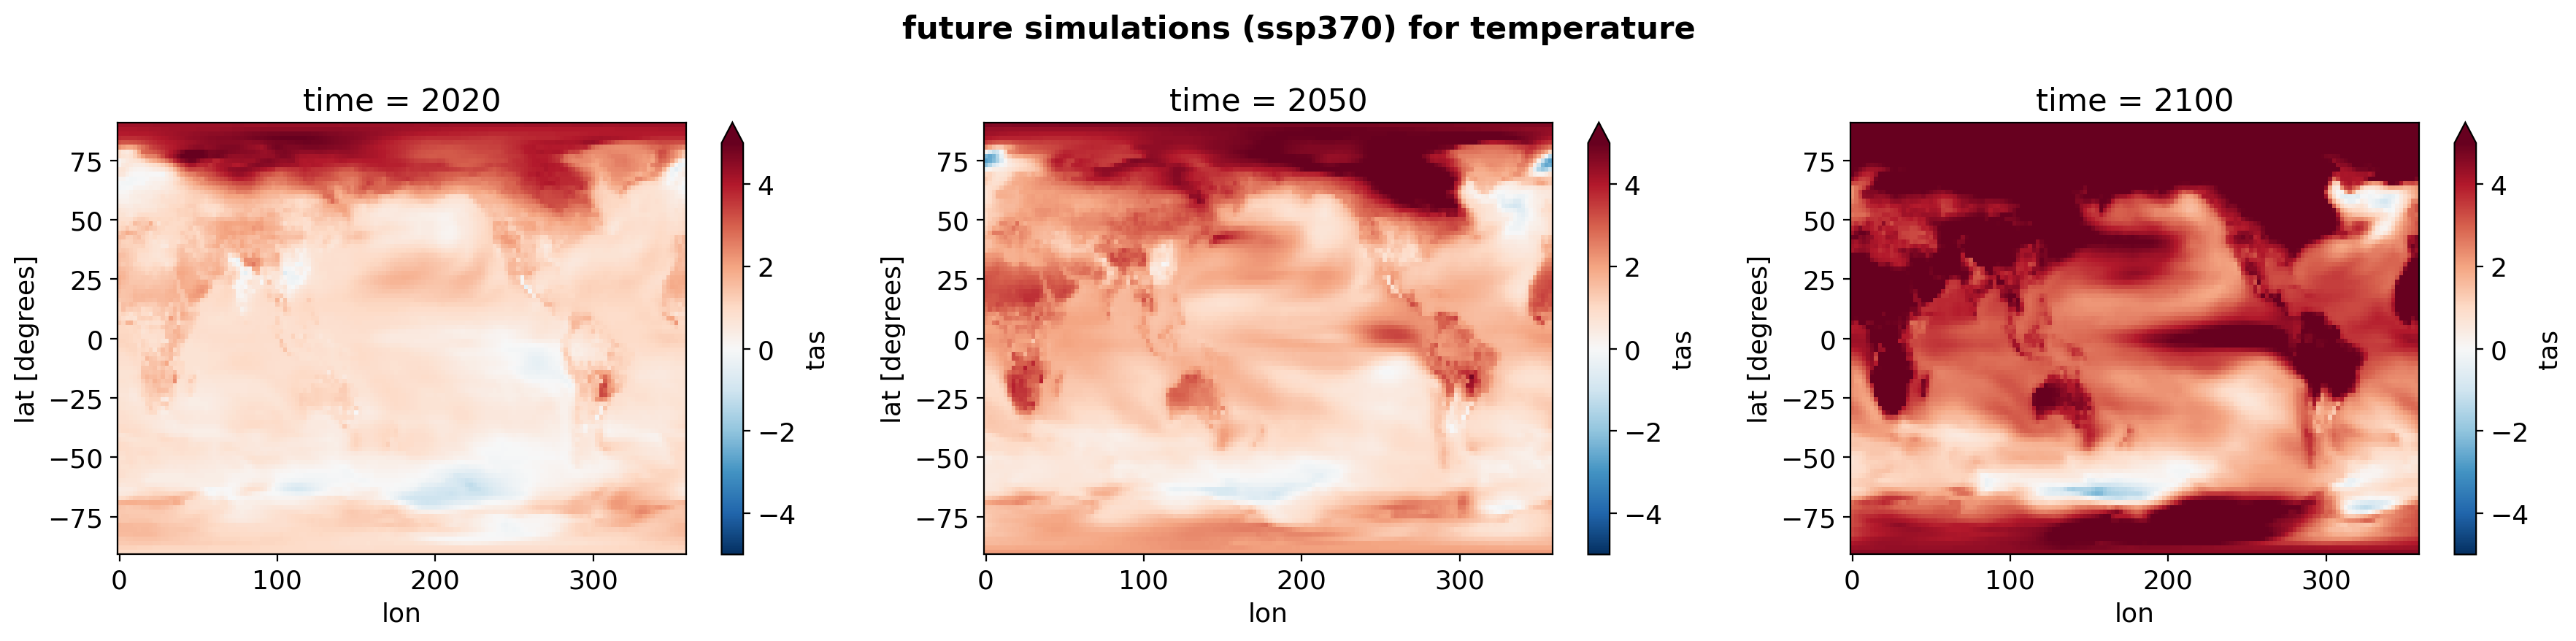

In [8]:
y_ssp370 = open_dataset(os.path.join(train_path,'outputs_ssp370')).mean(dim="member")[['tas']].drop(['quantile'])


fig,axes = plt.subplots(figsize=(18,4.5),ncols=3)
yr0, yr1, yr2 = 2020, 2050, 2100
vmin, vmax = -5, 5

y_ssp370.sel(time=yr0).tas.plot(ax=axes.flat[0],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr1).tas.plot(ax=axes.flat[1],vmin=vmin,vmax=vmax,cmap='RdBu_r')
y_ssp370.sel(time=yr2).tas.plot(ax=axes.flat[2],vmin=vmin,vmax=vmax,cmap='RdBu_r')

fig.suptitle('future simulations (ssp370) for temperature',fontweight='bold')
plt.tight_layout()

## Use Neural Networks (NN) for temperature prediction


Now, we are trying to use NN to predict the surface air temperature (tas), based on the time series of CO2 & CH4 emissions

### 1. data preprocssing: prepare data for training & test sets

#### import data as training & test sets

Here we train NN using simulations from 3 historical and 3 future scenarios. <br/> Then we test the trained NN using the ssp245 scenario.

In [9]:
# Training set
train_files    = ["historical", "ssp585", "ssp126", "ssp370","hist-aer","hist-GHG"]
X_train_xr, _  = prepare_predictor(train_files,train_path)
y_train_xr, _  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2 & CH4 <br/>
predictand: tas

In [10]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)


y_train_df = y_train_xr["tas"].stack({"stacked": ("latitude", "longitude")})
y_train_df = pd.DataFrame(y_train_df.to_pandas())

This is how our predictors & predictand data look like:

In [11]:
X_train_df.head()

,CO2,CH4
0,0.188297,0.031306
1,0.377244,0.031742
2,0.573814,0.032178
3,0.778848,0.032614
4,1.020320,0.033049


Note that here we stack the original 2-D tas data into a single dimension (for the purpose of NN implementation)

In [12]:
y_train_df.head()

latitude      -90.0                                                    \
longitude     0.0       2.5       5.0       7.5       10.0      12.5    
time                                                                    
0          0.320023  0.319946  0.319865  0.319885  0.319860  0.319865   
1         -0.667297 -0.667023 -0.667114 -0.667109 -0.667109 -0.667135   
2         -0.058345 -0.058167 -0.058248 -0.058243 -0.058248 -0.058248   
3          0.125870  0.125941  0.125946  0.125941  0.125946  0.125890   
4          0.418304  0.418533  0.418503  0.418523  0.418477  0.418513   

latitude                                           ...      90.0            \
longitude     15.0      17.5      20.0      22.5   ...     335.0     337.5   
time                                               ...                       
0          0.319870  0.319911  0.319763  0.319707  ...  0.913116  0.913289   
1         -0.667114 -0.667104 -0.667104 -0.666992  ...  0.042501  0.042679   
2         -0.058233 -0.058207 -0.058345 -0.058177  ...  1.167440  1.167389   
3          0.125951  0.125941  0.125895  0.125982  ... -0.339457 -0.339589   
4          0.418503  0.418549  0.418482  0.418564  ...  0.577006  0.576996   

latitude                                                               \
longitude     340.0     342.5     345.0     347.5     350.0     352.5   
time                                                                    
0          0.913116  0.912933  0.912893  0.912659  0.912384  0.912181   
1          0.049225  0.055695  0.055506  0.055227  0.054789  0.054230   
2          1.169657  1.172119  1.172201  1.172190  1.172292  1.172424   
3         -0.332387 -0.324961 -0.324956 -0.325038 -0.325063 -0.325033   
4          0.585297  0.593811  0.593740  0.593719  0.593648  0.593801   

latitude                       
longitude     355.0     357.5  
time                           
0          0.911825  0.911611  
1          0.053604  0.052897  
2          1.172709  1.173228  
3         -0.325022 -0.324880  
4          0.593760  0.593943  

[5 rows x 13824 columns]

#### Data normalization

Let's normalize the input predictors by the mean & std

In [13]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

X_test = X_test_df.to_numpy()

# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), \
                                               torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

### 2. Define the NN structure

Now the data preprocessing has been finished! Let's define our NN structure, which is shown in the below schematic.

Here the NN we use has 3 hidden layers, and each hidden layer has 64 neurons. 

The NN input layer has 2 neurons, corresponding to CO2 & CH4 inputs respectively. 

The NN outputs are the global tas, each neuron of the output layer corresponds to each pixel. There are 13824 pixels in total (number of latitude: 96, number of longitude: 144)

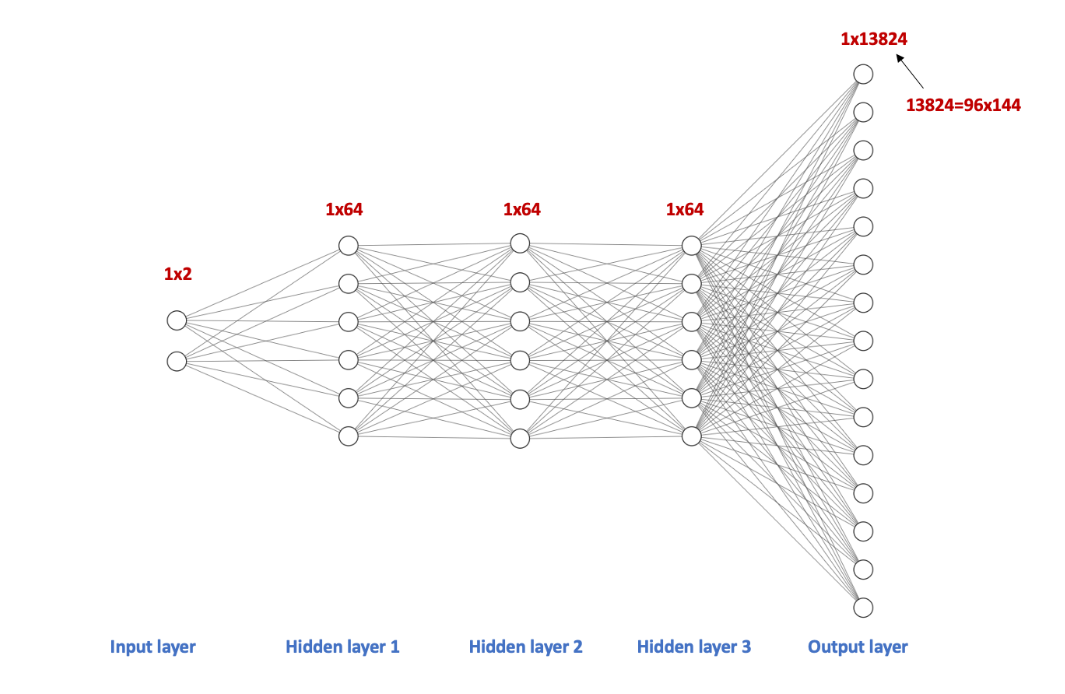

Here are the hyperparameters for the NN training, such as the number of neurons per layer, learning rate, etc. Note that these hyperparameters here are for demonstration purposes only - they are not optimized.  

In [14]:
# set hyperparameters
n_neuron       = 64
activation     = 'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 64
N_layers       = 2 # number of hidden layers

In [15]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [16]:
layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())

for n in range(N_layers-1):
   layers.append(nn.Linear(n_neuron, n_neuron))
   layers.append(getattr(nn, activation)())

layers.append(nn.Linear(n_neuron, y_train.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [17]:
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=13824, bias=True)
)


In [18]:
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=13824, bias=True)
)

### 3. Train & save the NN model

Here we stop early, if the validation loss does not improve for 20 epochs, to avoid over-fitting.

In [19]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 3.1144, Val Loss: 2.6194
Epoch 2/50, Train Loss: 2.7596, Val Loss: 2.2050
Epoch 3/50, Train Loss: 2.1350, Val Loss: 1.5929
Epoch 4/50, Train Loss: 1.4256, Val Loss: 0.9961
Epoch 5/50, Train Loss: 0.8765, Val Loss: 0.6412
Epoch 6/50, Train Loss: 0.5918, Val Loss: 0.4662
Epoch 7/50, Train Loss: 0.4469, Val Loss: 0.3997
Epoch 8/50, Train Loss: 0.3997, Val Loss: 0.3717
Epoch 9/50, Train Loss: 0.3798, Val Loss: 0.3581
Epoch 10/50, Train Loss: 0.3703, Val Loss: 0.3521
Epoch 11/50, Train Loss: 0.3645, Val Loss: 0.3488
Epoch 12/50, Train Loss: 0.3561, Val Loss: 0.3465
Epoch 13/50, Train Loss: 0.3559, Val Loss: 0.3445
Epoch 14/50, Train Loss: 0.3560, Val Loss: 0.3425
Epoch 15/50, Train Loss: 0.3558, Val Loss: 0.3410
Epoch 16/50, Train Loss: 0.3546, Val Loss: 0.3398
Epoch 17/50, Train Loss: 0.3518, Val Loss: 0.3389
Epoch 18/50, Train Loss: 0.3537, Val Loss: 0.3386
Epoch 19/50, Train Loss: 0.3493, Val Loss: 0.3373
Epoch 20/50, Train Loss: 0.3466, Val Loss: 0.3365
Epoch 21/

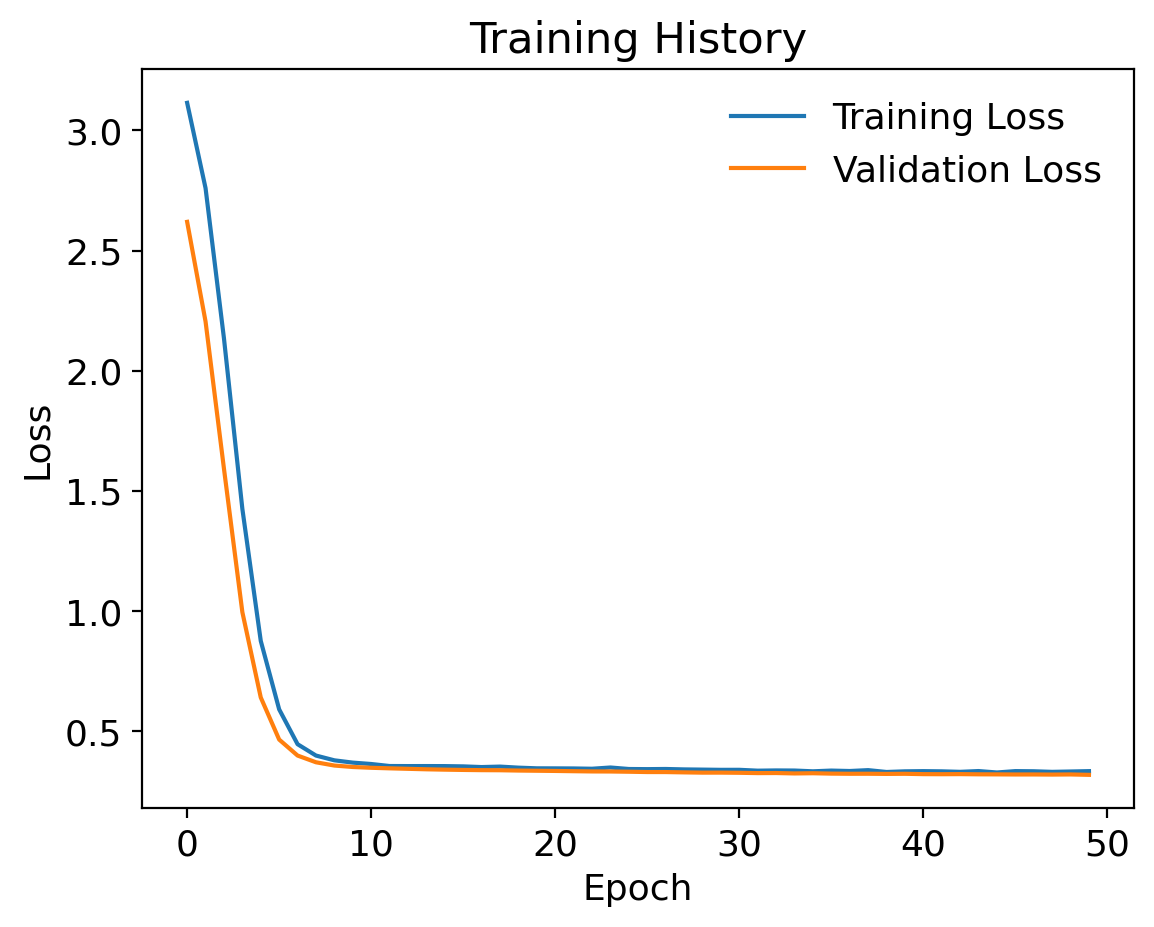

In [20]:
plot_history(train_losses, val_losses)

we can save the trained model as the `.h5` file.

In [21]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [22]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

### 4. Evaluate the trained model

Now let's evaluate the trained NN on the test set, by comparing the NN predictions against the tas originally simulated under the ssp245 scenario. 

In [23]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=2, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=13824, bias=True)
)

In [24]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model(batch_X)
       predictions.append(outputs.cpu().numpy())

y_test_pre = np.concatenate(predictions, axis=0)
y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': X_test_xr.time.values, 
                              'latitude': X_test_xr.latitude.values, 
                              'longitude': X_test_xr.longitude.values},
                      data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

First we check whether the ML model can capture the spatial distribution of global temperature

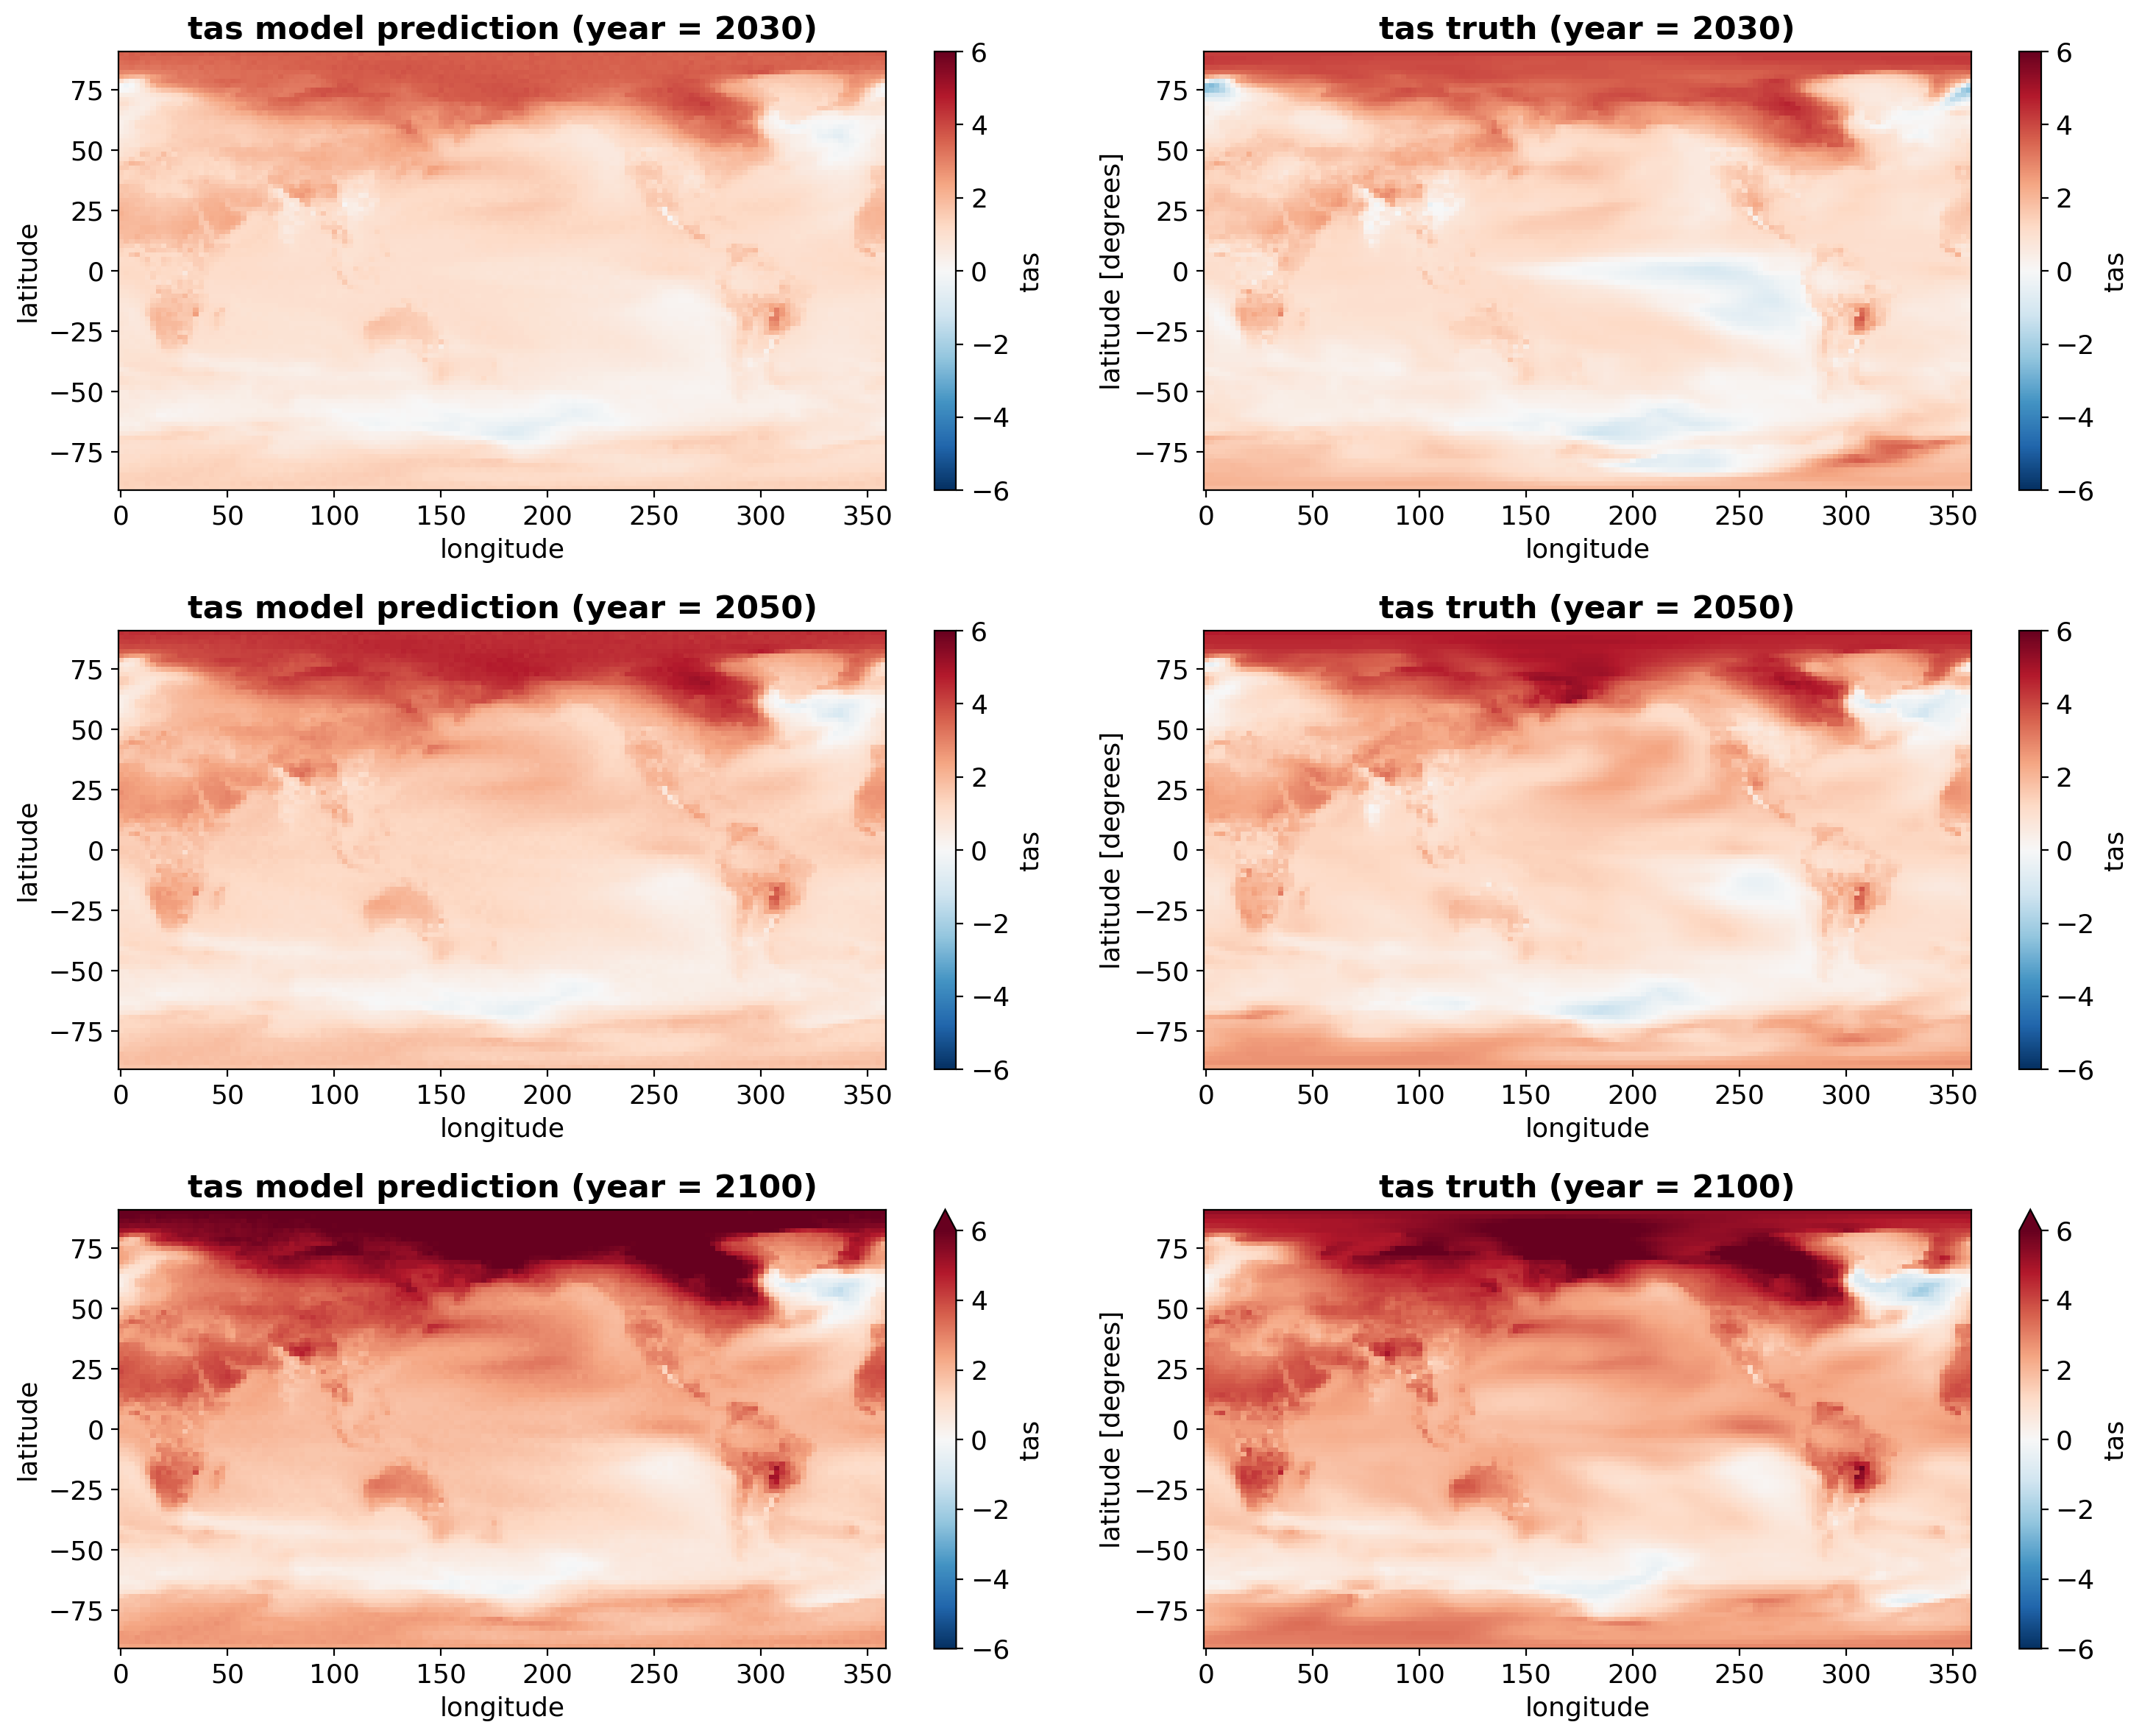

In [25]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'tas model prediction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

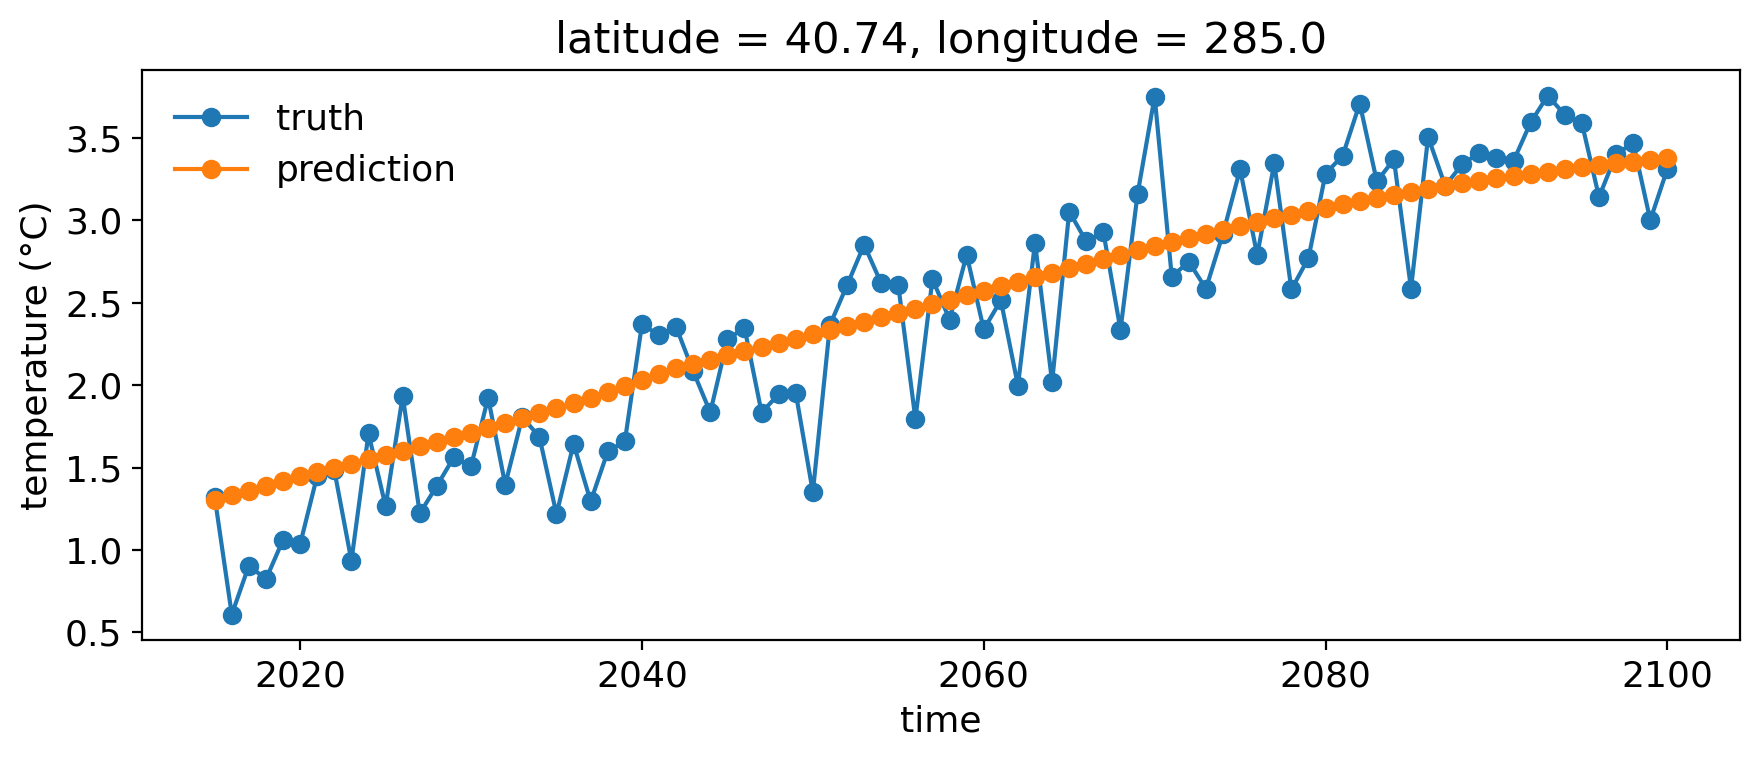

In [26]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction')

ax.legend()
ax.set_ylabel('temperature (°C)')

plt.tight_layout()

Let's check the statistical comparison between truth and prediction.

In [27]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_pre = y_test_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction"] = nyc_test_pre
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction
0  2015  1.321960    1.303621
1  2016  0.608693    1.331818
2  2017  0.905599    1.360287
3  2018  0.822795    1.389042
4  2019  1.061228    1.418106
5  2020  1.035349    1.447378
6  2021  1.451701    1.474130
7  2022  1.484253    1.500480
8  2023  0.934296    1.524766
9  2024  1.707011    1.549958


,time,truth,prediction
count,86.000000,86.000000,86.000000
mean,2057.500000,2.395548,2.458892
std,24.969982,0.836997,0.643135
min,2015.000000,0.608693,1.303621
25%,2036.250000,1.691455,1.900125
50%,2057.500000,2.456390,2.505968
75%,2078.750000,3.155296,3.051471
max,2100.000000,3.757050,3.377715


Finally we check whether the ML model can capture the time series of global average temperature 

In [28]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

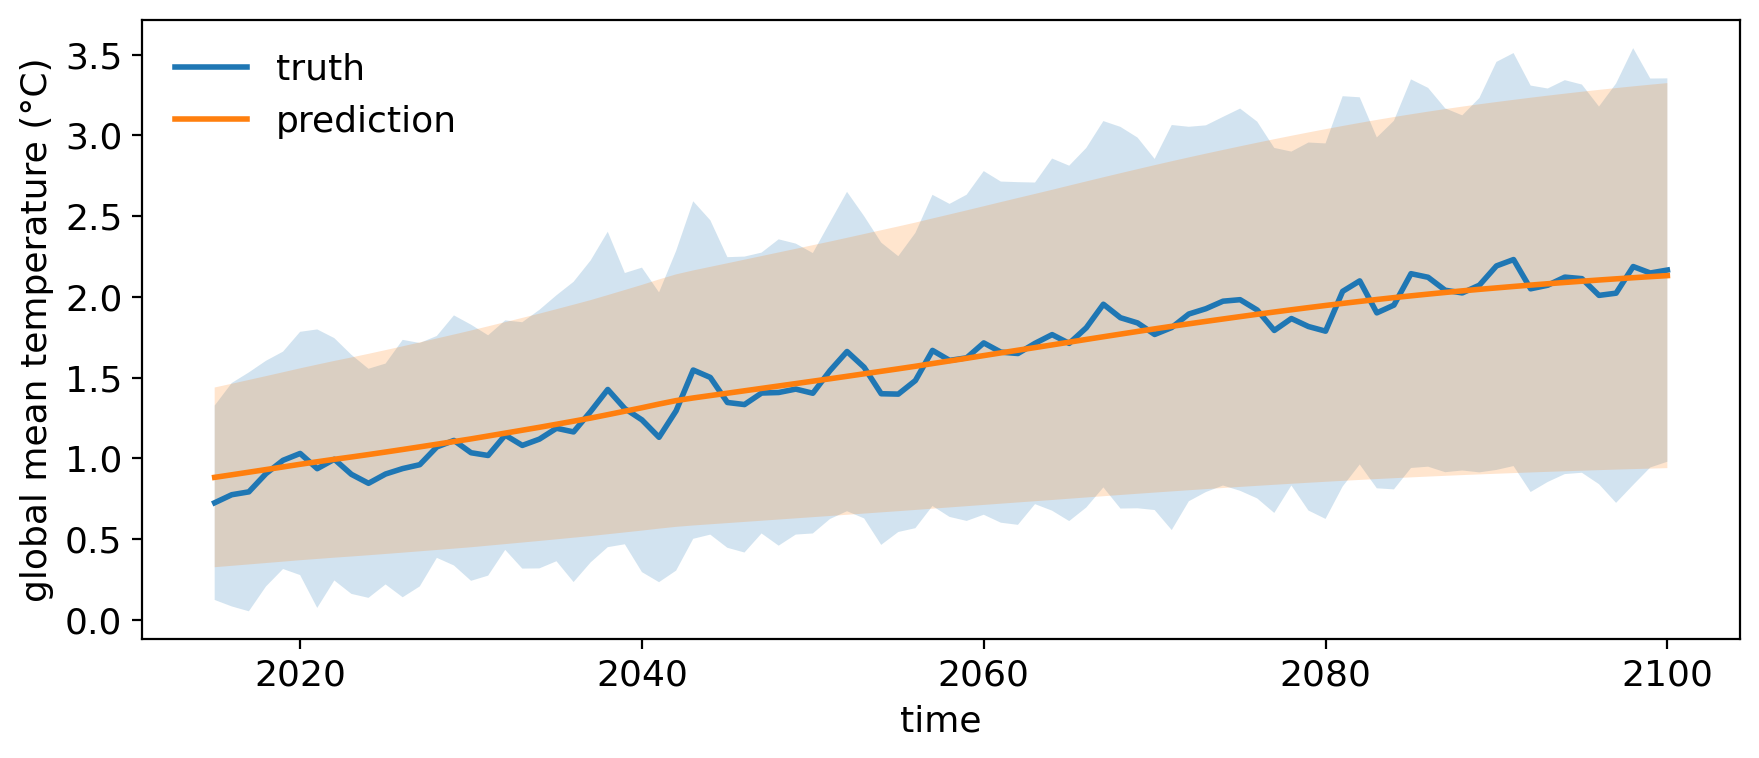

In [29]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_pre,label='prediction',ax=ax,color='tab:orange')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [30]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_pre = global_mean(y_test_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction"] = tas_mean_pre
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction
0  2015  0.724876    0.882164
1  2016  0.774634    0.898048
2  2017  0.792321    0.914087
3  2018  0.905029    0.930285
4  2019  0.987700    0.946651
5  2020  1.030206    0.963146
6  2021  0.935918    0.978595
7  2022  0.994084    0.993899
8  2023  0.900831    1.008328
9  2024  0.845252    1.023390


,time,truth,prediction
count,86.000000,86.000000,86.000000
mean,2057.500000,1.564246,1.571783
std,24.969982,0.430099,0.388396
min,2015.000000,0.724876,0.882164
25%,2036.250000,1.169074,1.234780
50%,2057.500000,1.635698,1.594863
75%,2078.750000,1.943204,1.929901
max,2100.000000,2.230782,2.131293
